In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emcee
from scipy.special import comb
import corner
from IPython.display import display, Math

def log_likelihood(theta, ns, nh, N):
    # ln(likelihood of data given model)
    rs, rh = theta
    likelihood = np.power(rs, ns) * np.power(rh, nh) * np.power(1.0-rs-rh, N-ns-nh) * comb(N, ns, exact=True) * comb(N-ns, nh)
    return np.log(likelihood)

def log_prior(theta):
    # ln(likelihood of model) in this case flat
    rs, rh = theta
    if 0.0 < rs < 1.0 and 0.0 < rh < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, ns, nh, N):
    # ln(likelihood of model given data) also the posterior
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ns, nh, N)


In [74]:
# [Soft, regular, hard]
# n_measured = np.array([64., 54., 47.]) # Pine
n_measured = np.array([52., 63., 71.]) # Deciduous
# n_measured = np.array([100, 90, 80])



# [soft rate, hard rate]
r_pos = np.array([n_measured[0]/np.sum(n_measured), n_measured[2]/np.sum(n_measured)]) + 1e-4*np.random.randn(32, 2)
nwalkers, ndim = r_pos.shape



sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(n_measured[0], n_measured[2], np.sum(n_measured)))
sampler.run_mcmc(r_pos, 5000, progress=True)


100%|██████████| 5000/5000 [00:07<00:00, 648.63it/s]


State([[0.27534696 0.38245105]
 [0.27775574 0.42787991]
 [0.23569786 0.36300027]
 [0.30598921 0.41016025]
 [0.3214786  0.33723714]
 [0.2987381  0.40566588]
 [0.25692505 0.39248935]
 [0.26997921 0.37830516]
 [0.31217812 0.39143147]
 [0.2620269  0.41169704]
 [0.24094611 0.39741748]
 [0.27604536 0.36183694]
 [0.33515986 0.37315156]
 [0.35183492 0.34358902]
 [0.3312628  0.40387551]
 [0.29904297 0.335351  ]
 [0.30600065 0.34246557]
 [0.28933472 0.36409609]
 [0.30878047 0.32217691]
 [0.24620129 0.40431184]
 [0.29721719 0.38840009]
 [0.28066543 0.42911879]
 [0.24822638 0.44412711]
 [0.29519914 0.33800041]
 [0.32936358 0.35602912]
 [0.26965012 0.39364698]
 [0.24006371 0.4093346 ]
 [0.22937814 0.3755935 ]
 [0.32768649 0.41344666]
 [0.26937224 0.40369792]
 [0.26286375 0.40946477]
 [0.26274167 0.45458702]], log_prob=[-5.41663235 -6.48125294 -7.17094638 -6.74150838 -6.46388272 -6.21649379
 -5.65315129 -5.48664819 -6.2951457  -5.76567309 -6.15102916 -5.65501021
 -7.00444608 -7.61609228 -8.07312819 

(5000, 32, 2)


Text(0.5, 0, 'step number')

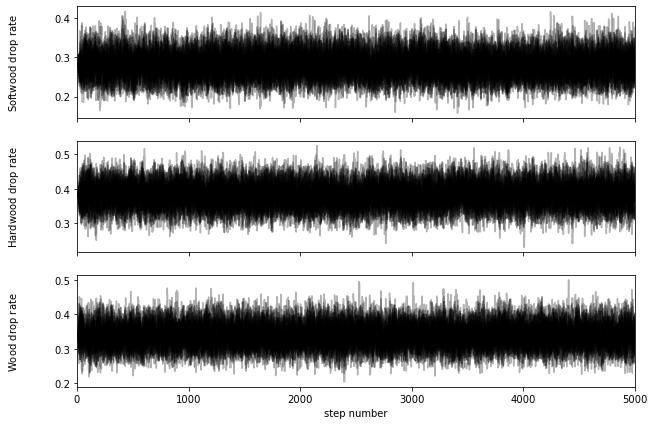

In [75]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples_temp = sampler.get_chain()
print(samples_temp.shape)
samples = np.zeros([samples_temp.shape[0], samples_temp.shape[1], 3])
samples[:,:,0] = samples_temp[:,:,0]
samples[:,:,1] = samples_temp[:,:,1]
samples[:,:,2] = 1.0 - samples_temp[:,:,0] - samples_temp[:,:,1]

ndim = 3
labels = [r"$\mathrm{Softwood\ drop\ rate}$", r"$\mathrm{Hardwood\ drop\ rate}$", r"$\mathrm{Wood\ drop\ rate}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

(156800, 2)


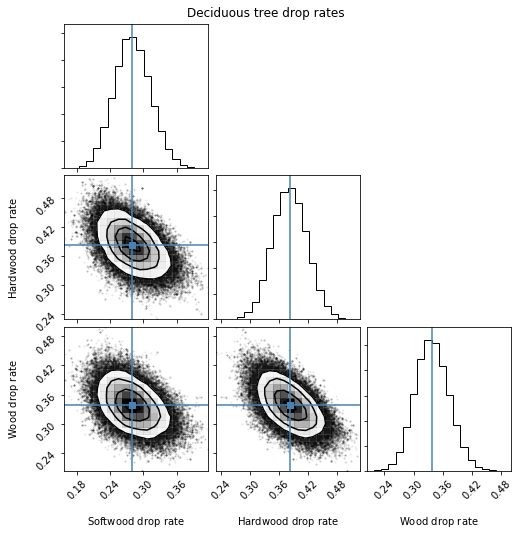

In [76]:
flat_samples_temp = sampler.get_chain(discard=100, flat=True)
print(flat_samples_temp.shape)
flat_samples = np.zeros([*flat_samples_temp.shape[:-1], 3])
# print(samples[:,:,2].shape)
# print(samples[:,:,2])
# print(samples[:,:,2].flatten().shape)
flat_samples[:,0] = flat_samples_temp[:,0]
flat_samples[:,1] = flat_samples_temp[:,1]
flat_samples[:,2] = samples[:,:,2].flatten()[100*nwalkers:]

fig = corner.corner(flat_samples, labels=labels, truths=[n_measured[0]/np.sum(n_measured), n_measured[2]/np.sum(n_measured), n_measured[1]/np.sum(n_measured)])
# fig.suptitle('Pine tree drop rates')
# plt.savefig('/Users/sean/Desktop/pine_rates.png')
fig.suptitle('Deciduous tree drop rates')
plt.savefig('/Users/sean/Desktop/deciduous_rates.png')


In [77]:
# print('Pine drop rates:')
print('Deciduous drop rates:')
new_labels = [r'$\mathrm{Softwood}$', r'$\mathrm{Hardwood}$', r'$\mathrm{Wood}$']
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [(1.0-0.682689)*100, 50.0, 0.682689*100])
    q = np.diff(mcmc)
    if round(q[0], 2) == round(q[1], 2):
        txt = r"$ : {0:.2f}\pm{1:.2f}$"
        txt = txt.format(mcmc[1], q[0], q[1])
    else:
        txt = r"$ : {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}$"
        txt = txt.format(mcmc[1], q[0], q[1])
    display(Math(new_labels[i] + txt))

Deciduous drop rates:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>